**Video Source**: https://drive.google.com/drive/folders/1NEqO0fvyva1dyceaNJlsIrmHDU-b-ypK?usp=sharing

**About the Execution Enviornment**: The code was run in Kaggle and a subset of the processed frames captured

In [3]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

### Motion Detection - Frame Differences

Motion detection through frame differences involves subtracting consecutive frames from a video stream to highlight areas of change. By comparing pixel intensity variations, regions exhibiting significant differences are identified as potential motion. Thresholding and filtering techniques are then applied to distinguish meaningful motion from noise, providing a basis for subsequent analysis or action.

Initial Frame Dimensions: (1080, 1920, 3)


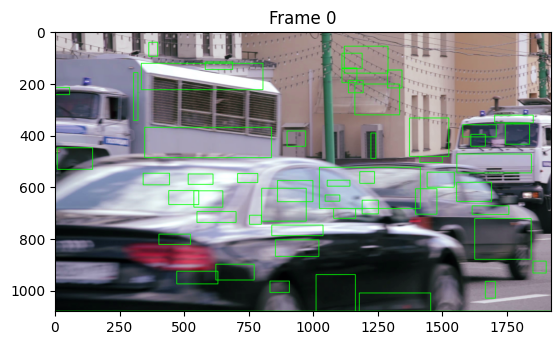

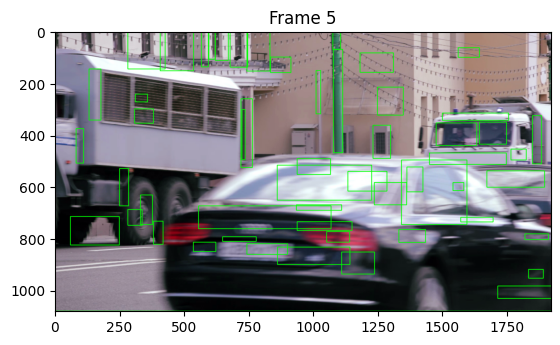

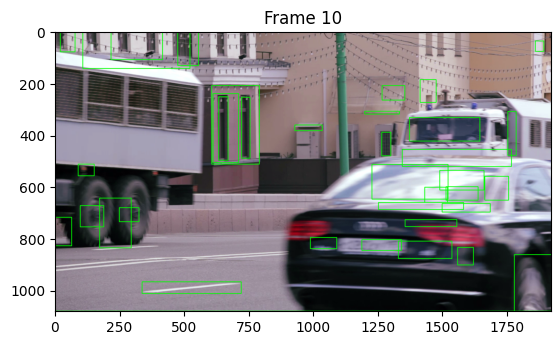

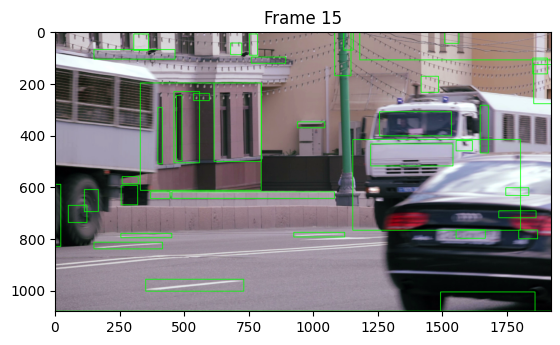

Frames saved in directory: /kaggle/working/frames


In [4]:
# Initialize video capture
cap = cv2.VideoCapture('/kaggle/input/va-test-traffic/VA_traffic.mov')

# Read two consecutive frames to initialize background
ret, frame1 = cap.read()
ret, frame2 = cap.read()

# Get the initial frame dimensions
height, width, channels = frame1.shape

# Print the initial frame dimensions
print("Initial Frame Dimensions:", (height, width, channels))

# Create a directory to store the frames
output_dir = '/kaggle/working/frames'
os.makedirs(output_dir, exist_ok=True)

# Counter to keep track of saved frames
frame_counter = 0

while frame_counter < 20:  # Save 20 frames
    # Read the next frame
    ret, frame2 = cap.read()

    # Check if the frame dimensions match the initial dimensions
    if frame2 is None or frame2.shape != (height, width, channels):
        print("Skipping frame due to dimension mismatch.")
        continue

    # Perform frame differencing
    diff = cv2.absdiff(frame1, frame2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, None, iterations=3)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw rectangles around moving objects
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) < 900:  # Adjust area threshold as needed
            continue
        cv2.rectangle(frame1, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save the frame as an image
    frame_filename = os.path.join(output_dir, f"frame_{frame_counter}.png")
    cv2.imwrite(frame_filename, frame1)

    # Display every 5th frame using Matplotlib
    if frame_counter % 5 == 0:
        plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_counter}")
        plt.show()

    # Update frames
    frame1 = frame2

    # Increment frame counter
    frame_counter += 1

# Release capture
cap.release()

print(f"Frames saved in directory: {output_dir}")


### Motion Estimation - Optical Flow
Motion estimation using optical flow involves analyzing the apparent motion of objects in consecutive frames of a video sequence. Optical flow algorithms track the displacement of pixels between frames, providing a vector field that represents the motion. This technique is widely used in various applications such as video compression, object tracking, and motion analysis in computer vision.


Initial Frame Dimensions: (1080, 1920, 3)


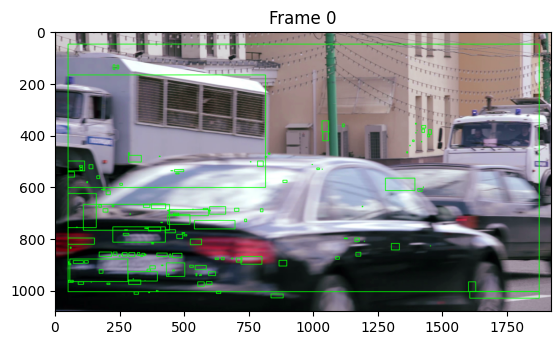

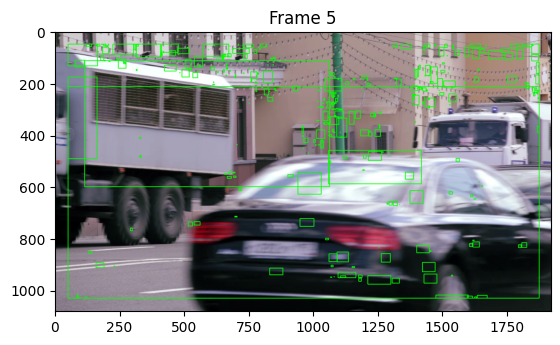

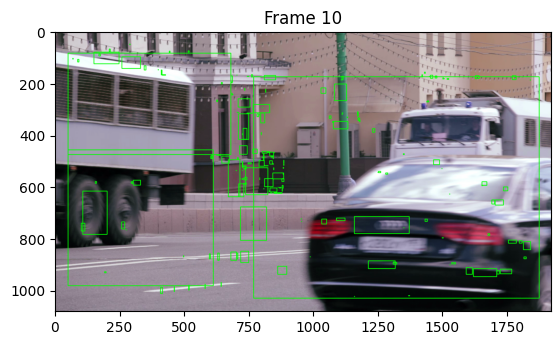

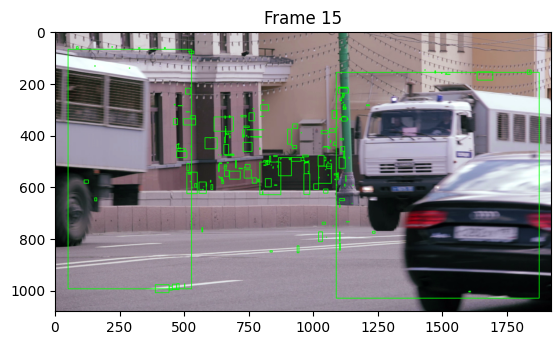

Frames saved in directory: /kaggle/working/frames_optical_flow_farneback


In [5]:

# Initialize video capture
cap = cv2.VideoCapture('/kaggle/input/va-test-traffic/VA_traffic.mov')

# Read two consecutive frames to initialize background
ret, frame1 = cap.read()
ret, frame2 = cap.read()

# Get the initial frame dimensions
height, width, channels = frame1.shape

# Print the initial frame dimensions
print("Initial Frame Dimensions:", (height, width, channels))

# Create a directory to store the frames
output_dir = '/kaggle/working/frames_optical_flow_farneback'
os.makedirs(output_dir, exist_ok=True)

# Counter to keep track of saved frames
frame_counter = 0

while frame_counter < 20:  # Save 20 frames
    # Read the next frame
    ret, frame2 = cap.read()

    # Check if the frame dimensions match the initial dimensions
    if frame2 is None or frame2.shape != (height, width, channels):
        print("Skipping frame due to dimension mismatch.")
        continue

    # Convert the current frame to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate Farneback optical flow
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None, 0.5, 5, 15, 5, 5, 1.1, 0
    )

    # Calculate the magnitude and angle of the flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Binarize the magnitude to identify moving pixels
    threshold = 5
    moving_pixels = (magnitude > threshold).astype(np.uint8) * 255

    # Apply a mask to focus on a region of interest (e.g., exclude the background)
    mask = np.zeros_like(gray1)
    mask[50:height-50, 50:width-50] = 1  # Adjust the region of interest

    # Apply the mask to the moving pixels
    moving_pixels = cv2.bitwise_and(moving_pixels, moving_pixels, mask=mask)

    # Find contours of moving pixels
    contours, _ = cv2.findContours(moving_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding rectangles around moving objects
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(frame2, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save the frame as an image
    frame_filename = os.path.join(output_dir, f"frame_{frame_counter}.png")
    cv2.imwrite(frame_filename, frame2)

    # Display every 5th frame using Matplotlib
    if frame_counter % 5 == 0:
        plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_counter}")
        plt.show()

    # Update frames
    frame1 = frame2

    # Increment frame counter
    frame_counter += 1

# Release capture
cap.release()

print(f"Frames saved in directory: {output_dir}")


### Motion Estimation Optical Flow with vectors using Lucas-Kanade method

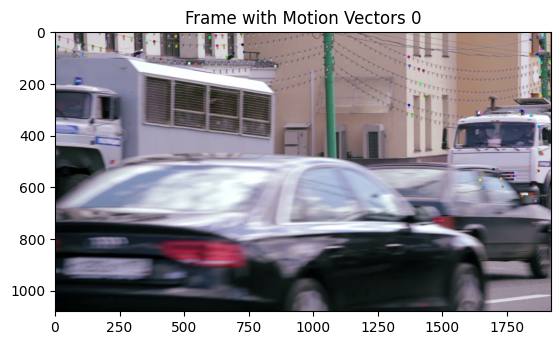

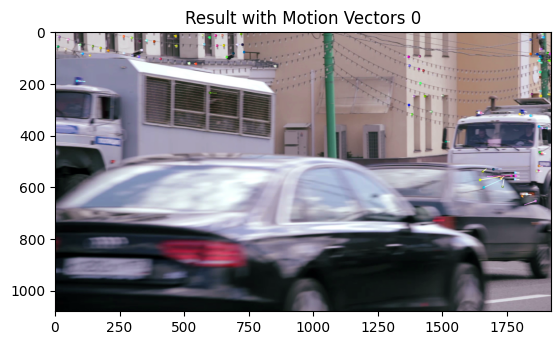

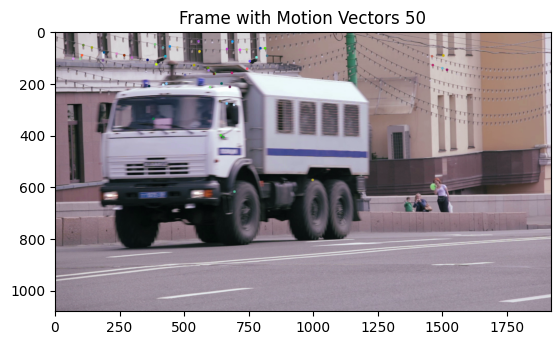

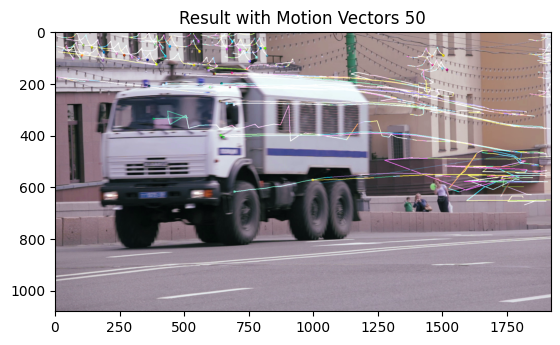

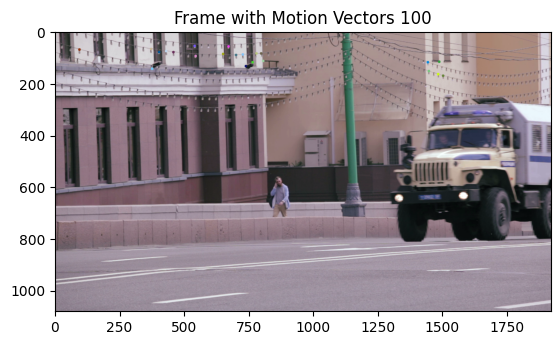

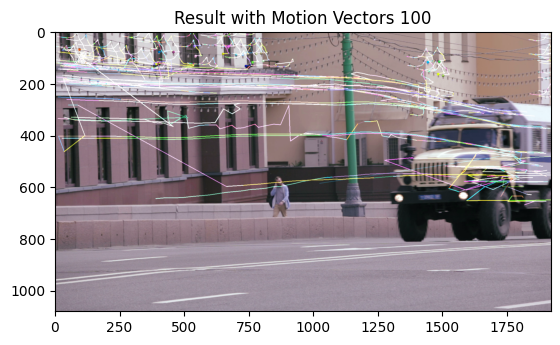

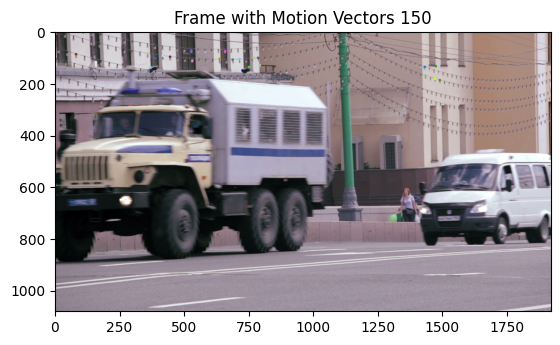

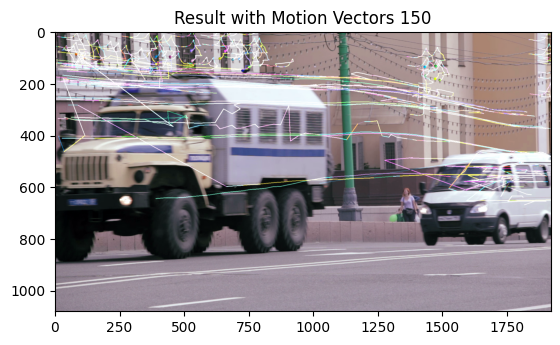

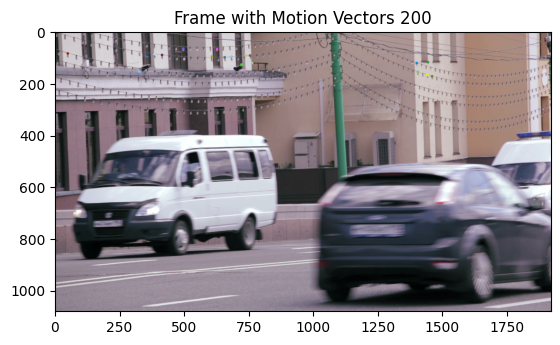

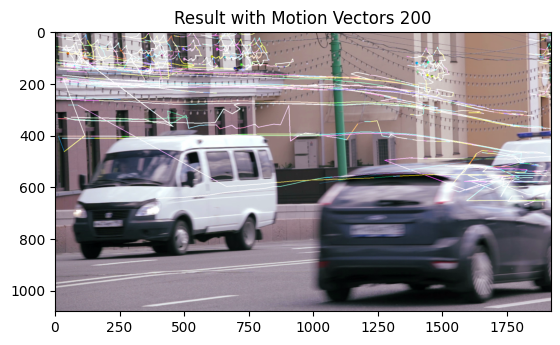

In [6]:

# Capture video from a file or a device
cap = cv2.VideoCapture('/kaggle/input/va-test-traffic/VA_traffic.mov')

# Assuming 'frame' and 'img' are NumPy arrays
def draw_motion_vectors(frame, mask, good_new, good_old, color):
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 4)  # Increase line thickness
        frame = cv2.circle(frame, (a, b), 7, color[i].tolist(), -1)  # Increase circle size
    return frame, mask

# params for corner detection 
feature_params = dict( maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7 ) 
  
# Parameters for lucas kanade optical flow 
lk_params = dict( winSize = (15, 15), maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)) 
  
# Create some random colors 
color = np.random.randint(0, 255, (100, 3)) 
  
# Take first frame and find corners in it 
ret, old_frame = cap.read() 
old_gray = cv2.cvtColor(old_frame, 
                        cv2.COLOR_BGR2GRAY) 
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, 
                             **feature_params) 
  
# Create a mask image for drawing purposes 
mask = np.zeros_like(old_frame) 

# Create a list to store frames with enhanced motion vectors
enhanced_frames = []

# Counter to keep track of saved frames
frame_counter = 0
  
while(1): 
      
    ret, frame = cap.read() 
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    # calculate optical flow 
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 
  
    # Select good points 
    good_new = p1[st == 1] 
    good_old = p0[st == 1] 
  
    # draw the tracks 
    for i, (new, old) in enumerate(zip(good_new, good_old)): 
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)     
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
          
    img = cv2.add(frame, mask)
    
    if frame_counter % 50 == 0:
        # Assuming 'frame' and 'img' are NumPy arrays
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame with Motion Vectors {frame_counter}")
        plt.show()

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Result with Motion Vectors {frame_counter}")
        plt.show()
    
    # Updating Previous frame and points  
    old_gray = frame_gray.copy() 
    p0 = good_new.reshape(-1, 1, 2) 
    
    # Increment frame counter
    frame_counter += 1
  
cap.release() 